### Data quality issues could arise due to various reasons, such as missing values, duplications, data integrity issues, data bias, data inconsistancy, outliers, data incompleteness, data inaccuracy, etc. For the sake of this assessment, I'm not going to evaluate every possibility and will focus on duplicate data, data inconsistancy, and data integrity issues.

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# These files are preprocessed in Power BI
df_brands = pd.read_csv("Brands.csv")
df_receipts = pd.read_csv("Receipts.csv")
df_receiptItem = pd.read_csv("ReceiptItem.csv")
df_users = pd.read_csv("Users1.csv")

df_brands.barcode = df_brands.barcode.astype(str)
df_receiptItem = df_receiptItem.rename(columns={"barcode": "Barcode"})
df_users = df_users.rename(columns={"_id.$oid": "userID", "createdDate.$date": "createdDate", "lastLogin.$date": "lastLoginDate"})

### Duplicate Data

This issue is actually found when I was creating a data model in Power BI. Power BI doesn't allow me to set the userId as primary key because it's duplicated. So I make a further step analysis here to check the distribution of all IDs.

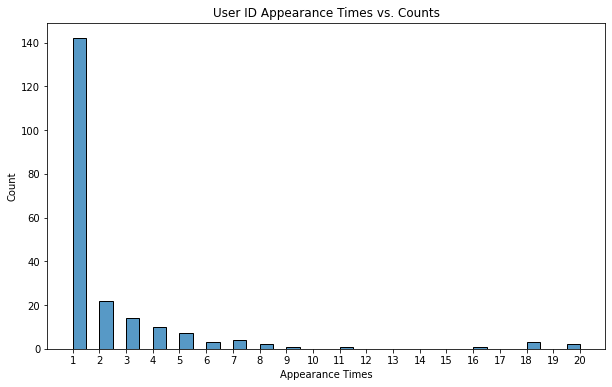

In [3]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.histplot(df_users.groupby("userID").count()["active"],
             binwidth=0.5)

ax.set_xlabel("Appearance Times")
ax.set_xticks(range(1, 21))
ax.set_title("User ID Appearance Times vs. Counts")
plt.show()

This plot describes the number of user IDs appearing with different frequencies. Appearently, most user IDs (~140) appears only once in Users table, which is great. However, there are other IDs appearing more than 1 time. The Users table should contain every user's record only once in this data model so we need to perform a further deduplication in Power BI or Python to make the data more meaningful.

In [4]:
df_users = df_users.drop_duplicates()

### Data Inconsistancy

This issue is also found during constructing the data model in Power BI. As I explained in Task 1, the relationship between Brands table and ReceiptItem table should be one-to-many via joining by the common key "barcode". However, it turns out that some brandIds share a common barcode, which would be inconsistant among these brands.

In [5]:
temp = df_brands.groupby("barcode").count().rename(columns={"brandId": "appearingTimes"})[["appearingTimes"]]
temp = temp[temp.appearingTimes > 1].reset_index()
temp

,barcode,appearingTimes
0,511111004790,2
1,511111204923,2
2,511111305125,2
3,511111504139,2
4,511111504788,2
5,511111605058,2
6,511111704140,2


In [6]:
df_brands[df_brands.barcode.isin(temp.barcode)].sort_values(by="barcode")

,brandId,barcode,brandCode,category,categoryCode,cpgId,cpgRef,name,topBrand
289,5c409ab4cd244a3539b84162,511111004790,ALEXA,Baking,NaN,55b62995e4b0d8e685c14213,Cogs,alexa,True
567,5cdacd63166eb33eb7ce0fa8,511111004790,BITTEN,Condiments & Sauces,NaN,559c2234e4b06aca36af13c6,Cogs,Bitten Dressing,NaN
205,5c45f91b87ff3552f950f027,511111204923,987654321,Grocery,NaN,5c45f8b087ff3552f950f026,Cogs,Brand1,True
507,5d6027f46d5f3b23d1bc7906,511111204923,CHESTERS,Snacks,NaN,5332f5fbe4b03c9a25efd0ba,Cogs,Chester's,NaN
166,5c4699f387ff3577e203ea29,511111305125,CHRISIMAGE,Baby,NaN,55b62995e4b0d8e685c14213,Cogs,Chris Image Test,NaN
330,5d642d65a3a018514994f42d,511111305125,511111305125,Magazines,NaN,5d5d4fd16d5f3b23d1bc7905,Cogs,Rachael Ray Everyday,NaN
197,5a7e0604e4b0aedb3b84afd3,511111504139,CHRISXYZ,Beverages,NaN,55b62995e4b0d8e685c14213,Cogs,Chris Brand XYZ,NaN
241,5a8c33f3e4b07f0a2dac8943,511111504139,PACE,Grocery,NaN,5a734034e4b0d58f376be874,Cogs,Pace,False
162,5c408e8bcd244a1fdb47aee7,511111504788,TEST,Baking,NaN,59ba6f1ce4b092b29c167346,Cogs,test,NaN
556,5ccb2ece166eb31bbbadccbe,511111504788,PIONEER WOMAN,Condiments & Sauces,NaN,559c2234e4b06aca36af13c6,Cogs,The Pioneer Woman,NaN


The first dataframe shows all barcodes which relate to more than 1 brand ID while the second displays those brands. As we can see, all brand sharing the same barcode seem doesn't have any relationship. Thus, this is another data quality issue which might affect analysis result, for example when calculating revenue, we might aggregate two products as one.

### Data Integrity Issue

Data integrity issues occur when the data violates defined constraints or rules, such as referential integrity in a relational database. Below are two examples the data violate the foreign key rule, i.e. users appearing in Receipt table don't exist in Users table & barcodes appearing in ReceiptItem table don't exist in Brands table. Typically, a good data model should consists a User table which contains all users information and a Brands table which contains all barcodes. But in this case, some extra information arise in Receipts table, which indicates that the data is not well integrated.

In [7]:
check_user_integrity = df_receipts.merge(df_users, left_on="userId", right_on="userID", how='outer')
check_user_integrity[check_user_integrity.userId.isnull()][["userID"]].drop_duplicates()

,userID
1119,5ff1e1e8cfcf6c399c274ad9
1120,5ff1e1b7cfcf6c399c274a5a
1121,5ff36d83135e7011bcb864d6
1122,5ff36c8862fde912123a538a
1123,5ff36c8e135e7011bcb85da4
...,...
1185,5f2068904928021530f8fc34
1186,6008622ebe5fc9247bab4eb9
1187,55308179e4b0eabd8f99caa2
1188,6006f786fb296c7f688530f8


In [8]:
check_barcode_integrity = df_brands.merge(df_receiptItem, left_on='barcode', right_on='Barcode', how='outer')
check_barcode_integrity[check_barcode_integrity.barcode.isnull()][["Barcode"]].drop_duplicates()

,Barcode
1239,4011
1416,028400642255
1429,NaN
5280,1234
5312,046000832517
...,...
8015,B076FJ92M4
8055,B07BRRLSVC
8095,B08BGBHHP6
8096,B08DQDHR2S
